<table style="width: 100%; margin-left: auto; margin-right: auto; background-color: white;">
<tbody>
<tr>

<td style="text-align: center; width: 12%;"><img src="imagens/brasil-brasao.png" alt="" /></td>

<td style="width: 68%;">
<h2 style="text-align: center; margin-top: 1%;">Governo do Brasil</h2>
<h2 style="text-align: center; margin-top: 1%;">Minist&eacute;rio da Educa&ccedil;&atilde;o</h2>
<h2 style="text-align: center; margin-top: 1%;">Universidade Federal do Amazonas</h2>
<h2 style="text-align: center; margin-top: 1%;">Instituto de Computa&ccedil;&atilde;o</h2>
</td>

<td style="width: 12%;"><img src="imagens/UFAM-logo.png" alt="" /></td>

</tr>
</tbody>
</table>

# Aprendizado de Máquina e Mineração de Dados
## Projeto Final de Disciplina, v. 1.0

Professores _Marco Cristo_ e _Eulanda Santos_

**Alunos**

Neste trabalho, você vai usar dados do INEP sobre o ENADE 2014 realizado por alunos de Pedagogia da região Sudeste do Brasil. Os dados a serem usados estão descritos em anexo a este documento e serão disponibilizados com o trabalho. Seu objetivo é prever se um aluno vai ou não passar no ENADE, ou seja, se sua nota média geral (NT_GER) será maior que 50. 

__Requisitos__:

* A solução deve ser feita usando as biliotecas sklearn, tensorflow e keras;
* O relatório deve ser entregue como um notebook Jupyter;
* O relatório deve incluir todos os passos de transformação de dados executados;
* Devem ser apresentados os seguintes modelos:
    * RandomForest;
    * Rede Neural com pelo menos duas camadas ocultas;
        * Modelo simples;
        * Modelo com normalização em batch;
        * Modelo com Dropout;
* Todos os modelos acima devem ser avaliados sob as mesmas condições;
    
__Avaliação__:

* 80% da nota associado ao trabalho entregue;
* 20% da nota associado ao resultado obtido pelos modelos;
    
__Observações__:

* Trabalho para equipes de até duas pessoas;
* Códigos-base em Keras para a FNN são fornecidos abaixo;

# Códigos base para implementação de rede neural em Keras

In [1]:
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score as sklearn_roc_auc_score
from sklearn.metrics import accuracy_score as sklearn_accuracy_score
from sklearn.metrics import confusion_matrix as sklearn_confusion_matrix
from sklearn.model_selection import train_test_split

In [29]:
from keras import optimizers
from keras import backend as K
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
def plot_model_history(model_history):
    # summarize history for loss
    plt.plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    plt.plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='best')
    plt.show()

In [40]:
def get_model_with_neural_network(X_input_size, layers, optmizer):
    '''
        get_model cria um modelo de rede neural  
        X_input_size: número de atributos em X
    '''
    input_data = Input(name='input', shape=(X_input_size,), dtype='float32')
    
    x = input_data
    for layer in layers:
        x = layer(x)

    y_pred = Activation('sigmoid')(x)
    
    model = Model(inputs=input_data, outputs=y_pred)
    
    # função de custo usada é a entropia cruzada
    model.compile(loss='binary_crossentropy', optimizer = optimizer) 
    
    return model

In [26]:
def train_model(model, X_train, X_test, y_train, y_test, 
                bsize = 200, n_epochs = 1000, val_proportion = 0.2, patience = 20, verbose = 2):

    # estratégia de treino com parada antecipada consiste em parar o treino
    # quando nenhuma melhoria no erro de validação (val_loss) é observada após
    # "patience" épocas
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=patience, \
                verbose=verbose, mode='auto')
    callback_list = [earlystop]
    
    # Modelo usa parâmetros comuns que podem ser modificados
    h = model.fit(X_train, y_train, batch_size=bsize, epochs=n_epochs,
                  verbose=2, shuffle = True, callbacks = callback_list, 
                  validation_split=val_proportion)
    plot_model_history(h)          
    
    # avaliação
    print('\nEstimating AUCROC, acc')
    y_pred = model.predict(X_test, batch_size=len(y_test))
    print('ROC value: %.4f'%(sklearn_roc_auc_score(y_test, y_pred)))
    print('Acc: %.4f'%(sklearn_accuracy_score(y_test, y_pred>0.5)))
    print('CMatrix: \n%s'%(sklearn_confusion_matrix(y_test, y_pred>0.5)))
    
    return model

#### Lendo os dados

In [7]:
enade2014 = pd.read_csv('datasets/e2014pedse.csv')
enade2014.head(5)

,CO_IES,CO_CATEGAD,CO_ORGACAD,CO_GRUPO,CO_CURSO,CO_UF_CURSO,CO_REGIAO_CURSO,NU_IDADE,TP_SEXO,ANO_FIM_2G,...,QE_I60,QE_I61,QE_I62,QE_I63,QE_I64,QE_I65,QE_I66,QE_I67,QE_I68,NT_INST
0,8,10002,10028,2001,697,MG,3,27,F,2004,...,1.0,6.0,5.0,5.0,5.0,8.0,5.0,4.0,6.0,0.721951
1,8,10002,10028,2001,697,MG,3,23,F,2008,...,3.0,4.0,5.0,5.0,6.0,4.0,6.0,6.0,6.0,0.800000
2,8,10002,10028,2001,697,MG,3,22,F,2009,...,4.0,5.0,5.0,5.0,4.0,4.0,6.0,6.0,6.0,0.942857
3,8,10002,10028,2001,697,MG,3,32,F,1999,...,5.0,5.0,5.0,5.0,6.0,5.0,6.0,5.0,5.0,0.833333
4,8,10002,10028,2001,697,MG,3,21,F,2010,...,1.0,2.0,2.0,2.0,4.0,1.0,5.0,4.0,4.0,0.690476


#### Lidando com missing data

In [8]:
column_nan_count = enade2014.apply(lambda col: sum(col.isna()), axis = 0)
column_nan_count[column_nan_count > 0]

Series([], dtype: int64)

Com isso vemos que não há nenhum valor NAN na base de dados.

#### Removendo atributos

O atributo **NT_INST** representa a nota da instituição. Ela é dada pelos alunos através das questões entre **QE_I27 e QE_I68**. Mais detalhes no anexo.
Como **NT_INST** representa esses atributos, podemos removê-los da base de dados.

In [9]:
columns_to_drop = map(lambda x: 'QE_I' + str(x), range(27, 69));
enade2014 = enade2014.drop(columns_to_drop, axis = 1)
enade2014.columns # colunas remanescentes

Index([u'CO_IES', u'CO_CATEGAD', u'CO_ORGACAD', u'CO_GRUPO', u'CO_CURSO',
       u'CO_UF_CURSO', u'CO_REGIAO_CURSO', u'NU_IDADE', u'TP_SEXO',
       u'ANO_FIM_2G', u'ANO_IN_GRAD', u'IN_MATUT', u'IN_VESPER', u'IN_NOTURNO',
       u'ID_STATUS', u'NT_GER', u'NT_FG', u'NT_OBJ_FG', u'NT_DIS_FG',
       u'NT_FG_D1', u'NT_FG_D1_PT', u'NT_FG_D1_CT', u'NT_FG_D2',
       u'NT_FG_D2_PT', u'NT_FG_D2_CT', u'NT_CE', u'NT_OBJ_CE', u'NT_DIS_CE',
       u'NT_CE_D1', u'NT_CE_D2', u'NT_CE_D3', u'QE_I01', u'QE_I02', u'QE_I03',
       u'QE_I04', u'QE_I05', u'QE_I06', u'QE_I07', u'QE_I08', u'QE_I09',
       u'QE_I10', u'QE_I11', u'QE_I12', u'QE_I13', u'QE_I14', u'QE_I15',
       u'QE_I16', u'QE_I17', u'QE_I18', u'QE_I19', u'QE_I20', u'QE_I21',
       u'QE_I22', u'QE_I23', u'QE_I24', u'QE_I25', u'QE_I26', u'NT_INST'],
      dtype='object')

Como o objetivo final é prever qual será a nota final do aluno, podemos remover as notas que o aluno tirou em cada módulo. Apenas o atributo **NT_GER** precisa ser mantido, pois é ele será usado para informar se o aluno passou ou não.

In [10]:
columns_to_drop = filter(lambda x: x.startswith('NT_'), enade2014.columns)
columns_to_drop.remove('NT_INST')
columns_to_drop.remove('NT_GER')

enade2014 = enade2014.drop(columns_to_drop, axis = 1)
enade2014.columns # colunas remanescentes

Index([u'CO_IES', u'CO_CATEGAD', u'CO_ORGACAD', u'CO_GRUPO', u'CO_CURSO',
       u'CO_UF_CURSO', u'CO_REGIAO_CURSO', u'NU_IDADE', u'TP_SEXO',
       u'ANO_FIM_2G', u'ANO_IN_GRAD', u'IN_MATUT', u'IN_VESPER', u'IN_NOTURNO',
       u'ID_STATUS', u'NT_GER', u'QE_I01', u'QE_I02', u'QE_I03', u'QE_I04',
       u'QE_I05', u'QE_I06', u'QE_I07', u'QE_I08', u'QE_I09', u'QE_I10',
       u'QE_I11', u'QE_I12', u'QE_I13', u'QE_I14', u'QE_I15', u'QE_I16',
       u'QE_I17', u'QE_I18', u'QE_I19', u'QE_I20', u'QE_I21', u'QE_I22',
       u'QE_I23', u'QE_I24', u'QE_I25', u'QE_I26', u'NT_INST'],
      dtype='object')

O atributo **ID_STATUS** também pode ser removido pois ele possui o mesmo valor em todas as amostras na base

In [11]:
enade2014 = enade2014.drop(['ID_STATUS'], axis = 1)
enade2014.columns # colunas remanescentes

Index([u'CO_IES', u'CO_CATEGAD', u'CO_ORGACAD', u'CO_GRUPO', u'CO_CURSO',
       u'CO_UF_CURSO', u'CO_REGIAO_CURSO', u'NU_IDADE', u'TP_SEXO',
       u'ANO_FIM_2G', u'ANO_IN_GRAD', u'IN_MATUT', u'IN_VESPER', u'IN_NOTURNO',
       u'NT_GER', u'QE_I01', u'QE_I02', u'QE_I03', u'QE_I04', u'QE_I05',
       u'QE_I06', u'QE_I07', u'QE_I08', u'QE_I09', u'QE_I10', u'QE_I11',
       u'QE_I12', u'QE_I13', u'QE_I14', u'QE_I15', u'QE_I16', u'QE_I17',
       u'QE_I18', u'QE_I19', u'QE_I20', u'QE_I21', u'QE_I22', u'QE_I23',
       u'QE_I24', u'QE_I25', u'QE_I26', u'NT_INST'],
      dtype='object')

In [12]:
columns = filter(lambda x: not x.startswith('QE'), enade2014.columns)
enade2014[columns].head(5)

,CO_IES,CO_CATEGAD,CO_ORGACAD,CO_GRUPO,CO_CURSO,CO_UF_CURSO,CO_REGIAO_CURSO,NU_IDADE,TP_SEXO,ANO_FIM_2G,ANO_IN_GRAD,IN_MATUT,IN_VESPER,IN_NOTURNO,NT_GER,NT_INST
0,8,10002,10028,2001,697,MG,3,27,F,2004,2009,0,0,1,67.4,0.721951
1,8,10002,10028,2001,697,MG,3,23,F,2008,2010,0,0,1,68.9,0.800000
2,8,10002,10028,2001,697,MG,3,22,F,2009,2010,0,0,1,53.7,0.942857
3,8,10002,10028,2001,697,MG,3,32,F,1999,2010,0,0,1,65.8,0.833333
4,8,10002,10028,2001,697,MG,3,21,F,2010,2011,0,0,1,56.5,0.690476


#### Normalização

Precisamos converter atributos com strings em valores categóricos.

In [13]:
e2014 = enade2014.copy(deep=True)

In [14]:
columns_type = e2014.dtypes
str_columns = columns_type[columns_type == 'object'].keys() # Nesta base, todas as amostras do tipo object são strings
e2014[str_columns].head(5)

,CO_UF_CURSO,TP_SEXO,QE_I01,QE_I02,QE_I03,QE_I04,QE_I05,QE_I06,QE_I07,QE_I08,...,QE_I17,QE_I18,QE_I19,QE_I20,QE_I21,QE_I22,QE_I23,QE_I24,QE_I25,QE_I26
0,MG,F,A,A,A,B,D,D,A,A,...,A,A,C,C,A,B,D,A,E,G
1,MG,F,A,A,A,C,E,D,C,C,...,B,A,B,A,A,C,B,E,E,C
2,MG,F,A,A,A,C,B,B,B,A,...,A,A,B,A,B,C,B,E,B,A
3,MG,F,A,B,A,B,C,D,C,A,...,A,A,B,C,B,B,B,C,A,F
4,MG,F,A,A,A,D,B,E,A,A,...,A,A,B,C,A,C,C,E,E,F


In [15]:
for c in str_columns:
    e2014[c] = e2014[c].astype('category').cat.codes

e2014[str_columns].head(5)

,CO_UF_CURSO,TP_SEXO,QE_I01,QE_I02,QE_I03,QE_I04,QE_I05,QE_I06,QE_I07,QE_I08,...,QE_I17,QE_I18,QE_I19,QE_I20,QE_I21,QE_I22,QE_I23,QE_I24,QE_I25,QE_I26
0,1,0,0,0,0,1,3,3,0,0,...,0,0,2,2,0,1,3,0,4,7
1,1,0,0,0,0,2,4,3,2,2,...,1,0,1,0,0,2,1,4,4,3
2,1,0,0,0,0,2,1,1,1,0,...,0,0,1,0,1,2,1,4,1,1
3,1,0,0,1,0,1,2,3,2,0,...,0,0,1,2,1,1,1,2,0,6
4,1,0,0,0,0,3,1,4,0,0,...,0,0,1,2,0,2,2,4,4,6


Agora precisamos converter todos os atributos não-binários para hot-vectors.

In [16]:
binary_columns = ['TP_SEXO', 'IN_MATUT', 'IN_VESPER', 'IN_NOTURNO']
columns_to_convert_in_hot_vectors = filter(lambda x: x not in binary_columns, enade2014.columns)

numeric_columns = ['NT_INST', 'NT_GER']
columns_to_convert_in_hot_vectors = filter(lambda x: x not in numeric_columns, columns_to_convert_in_hot_vectors)

columns_to_convert_in_hot_vectors

['CO_IES',
 'CO_CATEGAD',
 'CO_ORGACAD',
 'CO_GRUPO',
 'CO_CURSO',
 'CO_UF_CURSO',
 'CO_REGIAO_CURSO',
 'NU_IDADE',
 'ANO_FIM_2G',
 'ANO_IN_GRAD',
 'QE_I01',
 'QE_I02',
 'QE_I03',
 'QE_I04',
 'QE_I05',
 'QE_I06',
 'QE_I07',
 'QE_I08',
 'QE_I09',
 'QE_I10',
 'QE_I11',
 'QE_I12',
 'QE_I13',
 'QE_I14',
 'QE_I15',
 'QE_I16',
 'QE_I17',
 'QE_I18',
 'QE_I19',
 'QE_I20',
 'QE_I21',
 'QE_I22',
 'QE_I23',
 'QE_I24',
 'QE_I25',
 'QE_I26']

In [17]:
for c in columns_to_convert_in_hot_vectors:
    column_dummies = pd.get_dummies(e2014[c], prefix = c)
    e2014 = e2014.drop(c, axis = 1).join(column_dummies)

e2014.head(5)

,TP_SEXO,IN_MATUT,IN_VESPER,IN_NOTURNO,NT_GER,NT_INST,CO_IES_6,CO_IES_7,CO_IES_8,CO_IES_15,...,QE_I26_0,QE_I26_1,QE_I26_2,QE_I26_3,QE_I26_4,QE_I26_5,QE_I26_6,QE_I26_7,QE_I26_8,QE_I26_9
0,0,0,0,1,67.4,0.721951,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,68.9,0.800000,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,1,53.7,0.942857,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,1,65.8,0.833333,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,1,56.5,0.690476,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


Por último, vamos padronizar os valores numéricos com o Z-Score

In [18]:
e2014['NT_INST'] = (enade2014['NT_INST'] - enade2014['NT_INST'].mean())/enade2014['NT_INST'].std()
e2014['NT_INST'].head(5)

0   -0.659580
1   -0.212373
2    0.606176
3   -0.021378
4   -0.839927
Name: NT_INST, dtype: float64

#### Classificação 

Agora que os dados foram tratados eles podem ser passados aos modelos para estimar se um aluno irá ou não passar no ENADE.

In [19]:
X_columns = list(e2014.columns.values)
X_columns.remove('NT_GER')

X = e2014[X_columns].values
X

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [20]:
Y = e2014.NT_GER.apply(lambda v: 0 if v < 50 else 1).values
Y

array([1, 1, 1, ..., 1, 1, 1])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)

#### Random Forest

In [22]:
random_forest_model = RandomForestClassifier(n_estimators = 100, max_depth=5, random_state=0)
random_forest_model.fit(X_train, y_train)
random_forest_model.score(X_test, y_test)

0.6252294781012326

In [23]:
print('\nEstimating AUCROC, acc')
y_pred = random_forest_model.predict(X_test)
print('ROC value: %.4f'%(sklearn_roc_auc_score(y_test, y_pred)))
print('Acc: %.4f'%(sklearn_accuracy_score(y_test, y_pred>0.5)))
print('CMatrix: \n%s'%(sklearn_confusion_matrix(y_test, y_pred>0.5)))


Estimating AUCROC, acc
ROC value: 0.6313
Acc: 0.6252
CMatrix: 
[[1533  315]
 [1114  851]]


#### Redes neurais

In [86]:
# exibe arquitetura e número de parâmetros no modelo

# camadas passadas no enunciado do trabalho
layers = [
    Dense(units = 10),
    BatchNormalization(),
    Activation('sigmoid'),
    Dropout(0.5),
    Dense(units = 10),
    BatchNormalization(),
    Activation('sigmoid'),
    Dropout(0.5),    
    Dense(units = 1)
]

  
# modelo será treinado com otimizador SGD -- vc pode trocar o otimizador
optimizer = optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True)
    
neural_network_model = get_model_with_neural_network(len(X_columns), layers, optimizer)

neural_network_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1169)              0         
_________________________________________________________________
dense_75 (Dense)             (None, 10)                11700     
_________________________________________________________________
batch_normalization_27 (Batc (None, 10)                40        
_________________________________________________________________
activation_47 (Activation)   (None, 10)                0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 10)                110       
_________________________________________________________________
batch_normalization_28 (Batc (None, 10)                40        
__________

Train on 27446 samples, validate on 6862 samples
Epoch 1/100
 - 1s - loss: 0.6917 - val_loss: 0.6859
Epoch 2/100
 - 1s - loss: 0.6901 - val_loss: 0.6853
Epoch 3/100
 - 1s - loss: 0.6888 - val_loss: 0.6835
Epoch 4/100
 - 1s - loss: 0.6881 - val_loss: 0.6823
Epoch 5/100
 - 1s - loss: 0.6866 - val_loss: 0.6800
Epoch 6/100
 - 1s - loss: 0.6857 - val_loss: 0.6779
Epoch 7/100
 - 1s - loss: 0.6837 - val_loss: 0.6752
Epoch 8/100
 - 0s - loss: 0.6846 - val_loss: 0.6732
Epoch 9/100
 - 1s - loss: 0.6823 - val_loss: 0.6703
Epoch 10/100
 - 1s - loss: 0.6810 - val_loss: 0.6682
Epoch 11/100
 - 1s - loss: 0.6789 - val_loss: 0.6643
Epoch 12/100
 - 1s - loss: 0.6777 - val_loss: 0.6612
Epoch 13/100
 - 1s - loss: 0.6750 - val_loss: 0.6585
Epoch 14/100
 - 1s - loss: 0.6743 - val_loss: 0.6567
Epoch 15/100
 - 1s - loss: 0.6703 - val_loss: 0.6524
Epoch 16/100
 - 1s - loss: 0.6713 - val_loss: 0.6506
Epoch 17/100
 - 1s - loss: 0.6693 - val_loss: 0.6477
Epoch 18/100
 - 1s - loss: 0.6666 - val_loss: 0.6447
Epoch 

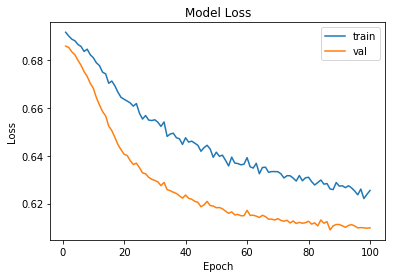


Estimating AUCROC, acc
ROC value: 0.7504
Acc: 0.6905
CMatrix: 
[[1225  623]
 [ 557 1408]]


In [88]:
train_model(neural_network_model, X_train, X_test, y_train, y_test, n_epochs = 100)

In [89]:
layers = [
    Dense(units = len(X_columns)/2),
    BatchNormalization(),
    Dropout(0.2),
    Dense(units = 1)
]

neural_network_model = get_model_with_neural_network(len(X_columns), layers, optimizer)
neural_network_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1169)              0         
_________________________________________________________________
dense_78 (Dense)             (None, 584)               683280    
_________________________________________________________________
batch_normalization_29 (Batc (None, 584)               2336      
_________________________________________________________________
dropout_35 (Dropout)         (None, 584)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 585       
_________________________________________________________________
activation_50 (Activation)   (None, 1)                 0         
Total params: 686,201
Trainable params: 685,033
Non-trainable params: 1,168
_________________________________________________________________


Train on 27446 samples, validate on 6862 samples
Epoch 1/100
 - 3s - loss: 0.6675 - val_loss: 0.6264
Epoch 2/100
 - 3s - loss: 0.6249 - val_loss: 0.6198
Epoch 3/100
 - 3s - loss: 0.6223 - val_loss: 0.6169
Epoch 4/100
 - 3s - loss: 0.6201 - val_loss: 0.6229
Epoch 5/100
 - 3s - loss: 0.6186 - val_loss: 0.6186
Epoch 6/100
 - 3s - loss: 0.6179 - val_loss: 0.6126
Epoch 7/100
 - 3s - loss: 0.6154 - val_loss: 0.6117
Epoch 8/100
 - 3s - loss: 0.6159 - val_loss: 0.6249
Epoch 9/100
 - 3s - loss: 0.6137 - val_loss: 0.6134
Epoch 10/100
 - 3s - loss: 0.6133 - val_loss: 0.6168
Epoch 11/100
 - 3s - loss: 0.6141 - val_loss: 0.6181
Epoch 12/100
 - 3s - loss: 0.6124 - val_loss: 0.6136
Epoch 13/100
 - 3s - loss: 0.6121 - val_loss: 0.6105
Epoch 14/100
 - 3s - loss: 0.6111 - val_loss: 0.6140
Epoch 15/100
 - 3s - loss: 0.6124 - val_loss: 0.6201
Epoch 16/100
 - 3s - loss: 0.6097 - val_loss: 0.6094
Epoch 17/100
 - 3s - loss: 0.6089 - val_loss: 0.6136
Epoch 18/100
 - 3s - loss: 0.6096 - val_loss: 0.6100
Epoch 

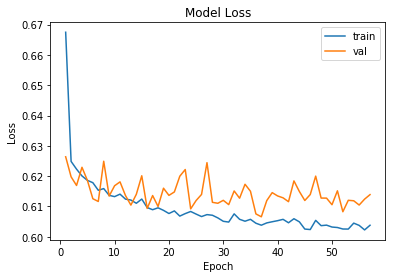


Estimating AUCROC, acc
ROC value: 0.7327
Acc: 0.6654
CMatrix: 
[[1285  563]
 [ 713 1252]]


In [90]:
train_model(neural_network_model, X_train, X_test, y_train, y_test, n_epochs = 100)

In [91]:
layers = [
    Dense(units = 100),
    Dropout(0.5),
    Dense(units = 1)
]

neural_network_model = get_model_with_neural_network(len(X_columns), layers, optimizer)
neural_network_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1169)              0         
_________________________________________________________________
dense_80 (Dense)             (None, 100)               117000    
_________________________________________________________________
dropout_36 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 101       
_________________________________________________________________
activation_51 (Activation)   (None, 1)                 0         
Total params: 117,101
Trainable params: 117,101
Non-trainable params: 0
_________________________________________________________________


Train on 27446 samples, validate on 6862 samples
Epoch 1/100
 - 2s - loss: 0.6579 - val_loss: 0.6284
Epoch 2/100
 - 1s - loss: 0.6290 - val_loss: 0.6182
Epoch 3/100
 - 1s - loss: 0.6206 - val_loss: 0.6137
Epoch 4/100
 - 1s - loss: 0.6158 - val_loss: 0.6117
Epoch 5/100
 - 1s - loss: 0.6144 - val_loss: 0.6121
Epoch 6/100
 - 1s - loss: 0.6118 - val_loss: 0.6091
Epoch 7/100
 - 1s - loss: 0.6100 - val_loss: 0.6096
Epoch 8/100
 - 1s - loss: 0.6079 - val_loss: 0.6074
Epoch 9/100
 - 1s - loss: 0.6082 - val_loss: 0.6080
Epoch 10/100
 - 1s - loss: 0.6066 - val_loss: 0.6070
Epoch 11/100
 - 1s - loss: 0.6063 - val_loss: 0.6059
Epoch 12/100
 - 1s - loss: 0.6050 - val_loss: 0.6070
Epoch 13/100
 - 1s - loss: 0.6046 - val_loss: 0.6058
Epoch 14/100
 - 1s - loss: 0.6039 - val_loss: 0.6056
Epoch 15/100
 - 1s - loss: 0.6032 - val_loss: 0.6048
Epoch 16/100
 - 1s - loss: 0.6026 - val_loss: 0.6063
Epoch 17/100
 - 1s - loss: 0.6011 - val_loss: 0.6051
Epoch 18/100
 - 1s - loss: 0.6024 - val_loss: 0.6040
Epoch 

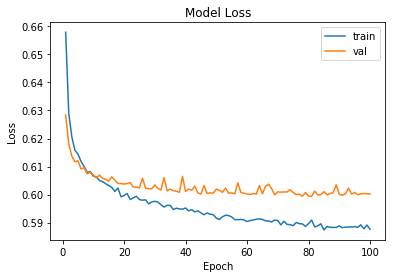


Estimating AUCROC, acc
ROC value: 0.7521
Acc: 0.6905
CMatrix: 
[[1324  524]
 [ 656 1309]]


In [92]:
train_model(neural_network_model, X_train, X_test, y_train, y_test, n_epochs = 100)

## ANEXO: Dicionário de Dados

**Dados da IES**

| **Coluna** | **Descrição** | **Valores** |
|--:|:--|:--|
| CO_IES | Código da IES (e-Mec) |  |
| CO_CATEGAD | Código da categoria administrativa da IES | 10002 = Pessoa Jurídica de Direito Público - Federal<br>10005 = Privada com fins lucrativos<br>10008 = Privada sem fins lucrativos |
| CO_ORGACAD | Código da organização acadêmica da IES | 10020 = Centro Universitário<br>10022 = Faculdade<br>10026 = Instituto Federal de Educação, Ciência e Tecnologia<br>10028 = Universidade |
| CO_GRUPO | Código da área de enquadramento do curso no Enade | 4004 = CIÊNCIA DA COMPUTAÇÃO (BACHARELADO)<br> 4006 = SISTEMAS DE INFORMAÇÃO |
| CO_UF_CURSO | Código da UF de funcionamento do curso | SP MG RS RJ SC PR PE DF BA CE GO AM PA PB MA ES MT PI MS AL RO TO SE RN AC RR AP | 
| CO_REGIAO_CURSO | Código da região de funcionamento do curso | 1 = Norte<br>2 = Nordeste<br>3 = Sudeste<br>4 = Sul<br>5 = Centro-Oeste |

**Dados dos Participantes**

| **Coluna** | **Descrição** | **Valores** |
|--:|:--|:--|
| NU_IDADE | Idade do inscrito em 23/11/2014 |  |
| TP_SEXO | Sexo | M = Masculino <br>F = Feminino |
| ANO_FIM_2G | Ano de conclusão do Ensino Médio |  |
| ANO_IN_GRAD | Ano de início da graduação |  |
| IN_MATUT | Indicador de turno matutino | 0 = Não <br>1 = Sim |
| IN_VESPER | Indicador de turno vespertino | 0 = Não <br>1 = Sim |
| IN_NOTURNO | Indicador de turno noturno | 0 = Não <br>1 = Sim |


**Notas dos Participantes**

| **Coluna** | **Descrição** |
|--:|:--|
| NT_GER | Nota bruta da prova - Média ponderada da formação geral (25%) e componente específico (75%). (valor de 0 a 100) |
| NT_FG | Nota bruta na formação geral - Média ponderada da parte objetiva (60%) e discursiva (40%) na formação geral.(valor de 0 a 100) |
| NT_OBJ_FG | Nota bruta na parte objetiva da formação geral. (valor de 0 a 100) |
| NT_DIS_FG | Nota bruta na parte discursiva da formação geral. (valor de 0 a 100) |
| NT_FG_D1 | Nota da questão 1 da parte discursiva da formação geral - Média ponderada da parte de Língua Portuguesa (20%) e Conteúdo (80%) da Questão 1 da parte discursiva. (valor de 0 a 100) |
| NT_FG_D1_PT | Nota de Língua Portuguesa da questão 1 da parte discursiva da formação geral. (valor de 0 a 100) |
| NT_FG_D1_CT | Nota de Conteúdo da questão 1 da parte discursiva da formação geral. (valor de 0 a 100)  |
| NT_FG_D2 | Nota da questão 2 da parte discursiva na formação geral - Média ponderada da parte de Língua Portuguesa (20%) e Conteúdo (80%) da Questão 2 da parte discursiva. (valor de 0 a 100) |
| NT_FG_D2_PT | Nota de Língua Portuguesa da questão 2 da parte discursiva da formação geral.(valor de 0 a 100)  |
| NT_FG_D2_CT | Nota de Conteúdo da questão 2 da parte discursiva da formação geral. (valor de 0 a 100)  |
| NT_CE | Nota bruta no componente específico - Média ponderada da parte objetiva (85%) e discursiva (15%) no componente específico. (valor de 0 a 100) |
| NT_OBJ_CE | Nota bruta na parte objetiva do componente específico. (valor de 0 a 100)  |
| NT_DIS_CE | Nota bruta na parte discursiva do componente específico. (valor de 0 a 100) |
| NT_CE_D1 | Nota da questão 1 da parte discursiva do componente específico. (valor de 0 a 100)  |
| NT_CE_D2 | Nota da questão 2 da parte discursiva do componente específico. (valor de 0 a 100)  |
| NT_CE_D3 | Nota da questão 3 da parte discursiva do componente específico. (valor de 0 a 100)  |

## Respostas aos Questionários

**Questionário sobre a prova**

| **Coluna** | **Descrição** | **Valores** |
|--:|:--|:--|
| CO_RS_I1 | 1 - Qual o grau de dificuldade desta prova na parte de Formação Geral? | A = Muito fácil.<br>B = Fácil.<br>C = Médio.<br>D = Difícil.<br>E = Muito difícil.<br>* = Resposta anulada<br>. = Não respondeu |
| CO_RS_I2 | 2 - Qual o grau de dificuldade desta prova na parte do Componente Específico? | A = Muito fácil.<br>B = Fácil.<br>C = Médio.<br>D = Difícil.<br>E = Muito difícil.<br>* = Resposta anulada<br>. = Não respondeu |
| CO_RS_I3 | 3 - Considerando a extensão da prova, em relação ao tempo total, você considera que a prova foi: | A = Muito longa.<br>B = Longa.<br>C = Adequada.<br>D = Curta.<br>E = Muito curta.<br>* = Resposta anulada<br>. = Não respondeu |
| CO_RS_I4 | 4 - Os enunciados das questões da prova na parte de Formação Geral estavam claros e objetivos? | A = Muito fácil.<br>B = Fácil.<br>C = Médio.<br>D = Difícil.<br>E = Muito difícil.<br>* = Resposta anulada<br>. = Não respondeu |
| CO_RS_I5 | 5 - Os enunciados das questões na parte do Componente Específico estavam claros e objetivos? | A = Muito fácil.<br>B = Fácil.<br>C = Médio.<br>D = Difícil.<br>E = Muito difícil.<br>* = Resposta anulada<br>. = Não respondeu |
| CO_RS_I6 | 6 - As informações/instruções fornecidas para a resolução das questões foram suficientes para resolvê-las? | A = Sim, até excessivas.<br>B = Sim, em todas elas.<br>C = Sim, na maioria delas.<br>D = Sim, somente em algumas.<br>E = Não, em nenhuma delas.<br>* = Resposta anulada<br>. = Não respondeu |
| CO_RS_I7 | 7 - Você se deparou com alguma dificuldade ao responder à prova. Qual? | A = Desconhecimento do conteúdo.<br>B = Forma diferente de abordagem do conteúdo.<br>C = Espaço insuficiente para responder às questões.<br>D = Falta de motivação para fazer a prova.<br>E = Não tive qualquer tipo de dificuldade para responder à prova.<br>* = Resposta anulada<br>. = Não respondeu |
| CO_RS_I8 | 8 - Considerando apenas as questões objetivas da prova, você percebeu que: | A = Não estudou ainda a maioria desses conteúdos.<br>B = Estudou alguns desses conteúdos, mas não os aprendeu.<br>C = Estudou a maioria desses conteúdos, mas não os aprendeu.<br>D = Estudou e aprendeu muitos desses conteúdos.<br>E = Estudou e aprendeu todos esses conteúdos.<br>* = Resposta anulada<br>. = Não respondeu |
| CO_RS_I9 | 9 - Qual foi o tempo gasto por você para concluir a prova? | A = Menos de uma hora.<br>B = Entre uma e duas horas.<br>C = Entre duas e três horas.<br>D = Entre três e quatro horas.<br>E = Quatro horas e não consegui terminar.<br>* = Resposta anulada<br>. = Não respondeu |

**Questionário sobre o candidato**

| **Coluna** | **Descrição** | **Valores** |
|--:|:--|:--|
| QE_I01 | Qual o seu estado civil? | A = Solteiro(a).<br>B = Casado(a).<br>C = Separado(a) judicialmente/divorciado(a).<br>D = Viúvo(a).<br>E = Outro. |
| QE_I02 | Como você se considera? | A = Branco(a).<br>B = Negro(a).<br>C = Pardo(a)/mulato(a).<br>D = Amarelo(a) (de origem oriental).<br>E = Indígena ou de origem indígena. |
| QE_I03 | Qual a sua nacionalidade? | A = Brasileira.<br>B = Brasileira naturalizada.<br>C = Estrangeira. |
| QE_I04 | Até que etapa de escolarização seu pai concluiu? | A = Nenhuma.<br>B = Ensino Fundamental: 1º ao 5º ano (1ª a 4ª série).<br>C = Ensino Fundamental: 6º ao 9º ano (5ª a 8ª série).<br>D = Ensino Médio.<br>E = Ensino Superior - Graduação.<br>F = Pós-graduação. |
| QE_I05 | Até que etapa de escolarização sua mãe concluiu? | A = Nenhuma.<br>B = Ensino fundamental: 1º ao 5º ano (1ª a 4ª série).<br>C = Ensino fundamental: 6º ao 9º ano (5ª a 8ª série).<br>D = Ensino médio.<br>E = Ensino Superior - Graduação.<br>F = Pós-graduação. |
| QE_I06 | Onde e com quem você mora atualmente? | A = Em casa ou apartamento, sozinho.<br>B = Em casa ou apartamento, com pais e/ou parentes.<br>C = Em casa ou apartamento, com cônjuge e/ou filhos.<br>D = Em casa ou apartamento, com outras pessoas (incluindo república).<br>E = Em alojamento universitário da própria instituição.<br>F = Em outros tipos de habitação individual ou coletiva (hotel, hospedaria, pensão ou outro) |
| QE_I07 | Quantas pessoas da sua família moram com você? Considere seus pais, irmãos, cônjuge, filhos e outros parentes que moram na mesma casa com você. | A = Nenhuma.<br>B = Uma.<br>C = Duas.<br>D = Três.<br>E = Quatro.<br>F = Cinco.<br>G = Seis.<br>H = Sete ou mais. |
| QE_I08 | Qual a renda total de sua família, incluindo seus rendimentos? | A = Até 1,5 salário mínimo (até R\$ 1.086,00).<br>B = De 1,5 a 3 salários mínimos (R\$ 1.086,01 a R\$ 2.172,00).<br>C = De 3 a 4,5 salários mínimos (R\$ 2.172,01 a R\$ 3.258,00).<br>D = De 4,5 a 6 salários mínimos (R\$ 3.258,01 a R\$ 4.344,00).<br>E = De 6 a 10 salários mínimos (R\$ 4.344,01 a R\$ 7.240,00).<br>F = De 10 a 30 salários mínimos (R\$ 7.240,01 a R\$ 21.720,00).<br>G = Acima de 30 salários mínimos (mais de R\$ 21.720,01). |
| QE_I09 | Qual alternativa a seguir melhor descreve sua situação financeira (incluindo bolsas)? | A = Não tenho renda e meus gastos são financiados por programas governamentais.<br>B = Não tenho renda e meus gastos são financiados pela minha família ou por outras pessoas.<br>C = Tenho renda, mas recebo ajuda da família ou de outras pessoas para financiar meus gastos.<br>D = Tenho renda e não preciso de ajuda para financiar meus gastos.<br>E = Tenho renda e contribuo com o sustento da família.<br>F = Sou o principal responsável pelo sustento da família. |
| QE_I10 | Qual alternativa a seguir melhor descreve sua situação de trabalho (exceto estágio ou bolsas)? | A = Não estou trabalhando.<br>B = Trabalho eventualmente.<br>C = Trabalho até 20 horas semanais.<br>D = Trabalho de 21 a 39 horas semanais.<br>E = Trabalho 40 horas semanais ou mais. |
| QE_I11 | Que tipo de bolsa de estudos ou financiamento do curso você recebeu para custear todas ou a maior parte das mensalidades? No caso de haver mais de uma opção, marcar apenas a bolsa de maior duração. | A = Nenhum, pois meu curso é gratuito.<br>B = Nenhum, embora meu curso não seja gratuito.<br>C = ProUni integral.<br>D = ProUni parcial, apenas.<br>E = FIES, apenas.<br>F = ProUni Parcial e FIES.<br>G = Bolsa oferecida por governo estadual, distrital ou municipal.<br>H = Bolsa oferecida pela própria instituição.<br>I = Bolsa oferecida por outra entidade (empresa, ONG, outra).<br>J = Financiamento oferecido pela própria instituição.<br>K = Financiamento bancário. |
| QE_I12 | Ao longo da sua trajetória acadêmica, você recebeu algum tipo de auxílio permanência? No caso de haver mais de uma opção, marcar apenas a bolsa de maior duração. | A = Nenhum.<br>B = Auxílio moradia.<br>C = Auxílio alimentação.<br>D = Auxílio moradia e alimentação.<br>E = Auxílio permanência.<br>F = Outro tipo de auxílio. |
| QE_I13 | Ao longo da sua trajetória acadêmica, você recebeu algum tipo de bolsa acadêmica? No caso de haver mais de uma opção, marcar apenas a bolsa de maior duração. | A = Nenhum.<br>B = Bolsa de iniciação científica.<br>C = Bolsa de extensão.<br>D = Bolsa de monitoria/tutoria.<br>E = Bolsa PET.<br>F = Outro tipo de bolsa acadêmica. |
| QE_I14 | Durante o curso de graduação você participou de programas e/ou atividades curriculares no exterior? | A = Não participei.<br>B = Sim, Programa Ciência sem Fronteiras.<br>C = Sim, programa de intercâmbio financiado pelo Governo Federal (Marca; Brafitec; PLI; outro).<br>D = Sim, programa de intercâmbio financiado pelo Governo Estadual.<br>E = Sim, programa de intercâmbio da minha instituição.<br>F = Sim, outro intercâmbio não institucional. |
| QE_I15 | Seu ingresso no curso de graduação se deu por meio de políticas de ação afirmativa ou inclusão social? | A = Não.<br>B = Sim, por critério étnico-racial.<br>C = Sim, por critério de renda.<br>D = Sim, por ter estudado em escola pública ou particular com bolsa de estudos.<br>E = Sim, por sistema que combina dois ou mais critérios anteriores.<br>F = Sim, por sistema diferente dos anteriores. |
| QE_I17 | Em que tipo de escola você cursou o ensino médio? | A = Todo em escola pública.<br>B = Todo em escola privada (particular).<br>C = Todo no exterior.<br>D = A maior parte em escola pública.<br>E = A maior parte em escola privada (particular).<br>F = Parte no Brasil e parte no exterior. |
| QE_I18 | Qual modalidade de ensino médio você concluiu? | A = Ensino médio tradicional.<br>B = Profissionalizante técnico (eletrônica, contabilidade, agrícola, outro).<br>C = Profissionalizante magistério (Curso Normal).<br>D = Educação de Jovens e Adultos (EJA) e/ou Supletivo.<br>E = Outra modalidade. |
| QE_I19 | Quem lhe deu maior incentivo para cursar a graduação? | A = Ninguém.<br>B = Pais.<br>C = Outros membros da família que não os pais.<br>D = Professores.<br>E = Líder ou representante religioso.<br>F = Colegas/Amigos.<br>G = Outras pessoas. |
| QE_I20 | Algum dos grupos abaixo foi determinante para você enfrentar dificuldades durante seu curso superior e concluí-lo? | A = Não tive dificuldade.<br>B = Não recebi apoio para enfrentar dificuldades.<br>C = Pais.<br>D = Avós.<br>E = Irmãos, primos ou tios.<br>F = Líder ou representante religioso.<br>G = Colegas de curso ou amigos.<br>H = Professores do curso.<br>I = Profissionais do serviço de apoio ao estudante da IES.<br>J = Colegas de trabalho.<br>K = Outro grupo. |
| QE_I21 | Alguém em sua família concluiu um curso superior? | A = Sim.<br>B = Não. |
| QE_I22 | Excetuando-se os livros indicados na bibliografia do seu curso, quantos livros você leu neste ano? |A = Nenhum.<br>B = Um ou dois.<br>C = De três a cinco.<br>D = De seis a oito.<br>E = Mais de oito. |
| QE_I23 | Quantas horas por semana, aproximadamente, você dedicou aos estudos, excetuando as horas de aula? | A = Nenhuma, apenas assisto às aulas.<br>B = De uma a três.<br>C = De quatro a sete.<br>D = De oito a doze.<br>E = Mais de doze. |
| QE_I24 | Você teve oportunidade de aprendizado de idioma estrangeiro na Instituição? | A = Sim, somente na modalidade presencial.<br>B = Sim, somente na modalidade semipresencial.<br>C = Sim, parte na modalidade presencial e parte na modalidade semipresencial.<br>D = Sim, na modalidade a distância.<br>E = Não. |
| QE_I25 | Qual o principal motivo para você ter escolhido este curso? | A = Inserção no mercado de trabalho.<br>B = Influência familiar.<br>C = Valorização profissional.<br>D = Prestígio Social.<br>E = Vocação.<br>F = Oferecido na modalidade a distância.<br>G = Baixa concorrência para ingresso.<br>H = Outro motivo. |
| QE_I26 | Qual a principal razão para você ter escolhido a sua instituição de educação superior? | A = Gratuidade.<br>B = Preço da mensalidade.<br>C = Proximidade da minha residência.<br>D = Proximidade do meu trabalho.<br>E = Facilidade de acesso.<br>F = Qualidade/reputação.<br>G = Foi a única onde tive aprovação.<br>H = Possibilidade de ter bolsa de estudo.<br>I = Outro motivo. |

**Questionário sobre o curso**

| **Coluna** | **Descrição** | **Valores** |
|--:|:--|:--|
| QE_I27 | As disciplinas cursadas contribuíram para sua formação integral, como cidadão e profissional. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I28 | Os conteúdos abordados nas disciplinas do curso favoreceram sua atuação em estágios ou em atividades de iniciação profissional. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I29 | As metodologias de ensino utilizadas no curso desafiaram você a aprofundar conhecimentos e desenvolver competências reflexivas e críticas. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I30 | O curso propiciou experiências de aprendizagem inovadoras. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I31 | O curso contribuiu para o desenvolvimento da sua consciência ética para o exercício profissional. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I32 | No curso você teve oportunidade de aprender a trabalhar em equipe. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I33 | O curso possibilitou aumentar sua capacidade de reflexão e argumentação. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I34 | O curso promoveu o desenvolvimento da sua capacidade de pensar criticamente, analisar e refletir sobre soluções para problemas da sociedade. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I35 | O curso contribuiu para você ampliar sua capacidade de comunicação nas formas oral e escrita. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I36 | O curso contribuiu para o desenvolvimento da sua capacidade de aprender e atualizar-se permanentemente. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I37 | As relações professor-aluno ao longo do curso estimularam você a estudar e aprender. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I38 | Os planos de ensino apresentados pelos professores contribuíram para o desenvolvimento das atividades acadêmicas e para seus estudos. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I39 | As referências bibliográficas indicadas pelos professores nos planos de ensino contribuíram para seus estudos e aprendizagens. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I40 | Foram oferecidas oportunidades para os estudantes superarem dificuldades relacionadas ao processo de formação. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I41 | A coordenação do curso esteve disponível para orientação acadêmica dos estudantes. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I42 | O curso exigiu de você organização e dedicação frequente aos estudos. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I43 | Foram oferecidas oportunidades para os estudantes participarem de programas, projetos ou atividades de extensão universitária. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I44 | Foram oferecidas oportunidades para os estudantes participarem de projetos de iniciação científica e de atividades que estimularam a investigação acadêmica. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I45 | O curso ofereceu condições para os estudantes participarem de eventos internos e/ou externos à instituição. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I46 | A instituição ofereceu oportunidades para os estudantes atuarem como representantes em órgãos colegiados. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I47 | O curso favoreceu a articulação do conhecimento teórico com atividades práticas. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I48 | As atividades práticas foram suficientes para relacionar os conteúdos do curso com a prática, contribuindo para sua formação profissional. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I49 | O curso propiciou acesso a conhecimentos atualizados e/ou contemporâneos em sua área de formação. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I50 | O estágio supervisionado proporcionou experiências diversificadas para a sua formação. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I51 | As atividades realizadas durante seu trabalho de conclusão de curso contribuíram para qualificar sua formação profissional | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I52 | Foram oferecidas oportunidades para os estudantes realizarem intercâmbios e/ou estágios no país. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I53 | Foram oferecidas oportunidades para os estudantes realizarem intercâmbios e/ou estágios fora do país. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I54 | Os estudantes participaram de avaliações periódicas do curso (disciplinas, atuação dos professores, infraestrutura). | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I55 | As avaliações da aprendizagem realizadas durante o curso foram compatíveis com os conteúdos ou temas trabalhados pelos professores. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I56 | Os professores apresentaram disponibilidade para atender os estudantes fora do horário das aulas. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I57 | Os professores demonstraram domínio dos conteúdos abordados nas disciplinas. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I58 | Os professores utilizaram tecnologias da informação e comunicação (TICs) como estratégia de ensino (projetor multimídia, laboratório de informática, ambiente virtual de aprendizagem). | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I59 | A instituição dispôs de quantidade suficiente de funcionários para o apoio administrativo e acadêmico. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I60 | O curso disponibilizou monitores ou tutores para auxiliar os estudantes. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I61 | As condições de infraestrutura das salas de aula foram adequadas. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I62 | Os equipamentos e materiais disponíveis para as aulas práticas foram adequados para a quantidade de estudantes. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I63 | Os ambientes e equipamentos destinados às aulas práticas foram adequados ao curso. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I64 | A biblioteca dispôs das referências bibliográficas que os estudantes necessitaram. |1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I65 | A instituição contou com biblioteca virtual ou conferiu acesso a obras disponíveis em acervos virtuais. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I66 | As atividades acadêmicas desenvolvidas dentro e fora da sala de aula possibilitaram reflexão, convivência e respeito à diversidade. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I67 | A instituição promoveu atividades de cultura, de lazer e de interação social. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |
| QE_I68 | A instituição dispôs de refeitório, cantina e banheiros em condições adequadas que atenderam as necessidades dos seus usuários. | 1 = Discordo Totalmente a 6 = Concordo Totalmente<br>7 = Não sei responder.<br>8 = Não se aplica. |